# Investigating my RunKeeper data with Python



This post is a little bit of an experiment, in two areas:

1. Playing with some of my own data, using a language that I'm quite familiar with (Python) and a mixture of tools which are old and new to me; and
2. Publishing that investigation directly on my blog, as a static IPython Notebook export.

The data I'll be using is information about my exercise that I've been tracking over the last few years using RunKeeper. RunKeeper allows you to export and download your full exercise history, including GPX files showing where you went on each activity, and a couple of summary files in CSV format. It's this latter that I'm going to take a look at; just an initial survey to see if there's anything interesting that jumps out.

I'm not expecting any massive insights just yet, but I hope you find this a useful introduction to some very valuable data wrangling and analysis tools.

## Looking at the data

First up, we need to do some basic setup:


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import display

This imports some Python packages that we'll need:

* matplotlib: makes pretty plots (the `%matplotlib inline` bit is some IPython Notebook magic to make plots appear inline)
* numpy: allows some maths and stats functions
* pandas: loads and manipulates tabular data

Next, let's check what files we have to work with:


In [3]:
%ls *.csv

cardioActivities.csv  measurements.csv


I'm interested in `cardioActivities.csv`, which contains a summary of each activity in my RunKeeper history. Loading it up gives us this:

In [20]:
cardio = pd.read_csv('cardioActivities.csv',
                     parse_dates=[1],
                     index_col=1)
display(cardio.head())
cardio.describe()

Activity Id      Type  \
Date                                                                  
2015-04-18 11:49:08  d7f0587f-4d31-4496-86a9-4aacb271207f   Running   
2015-04-15 07:17:00  c600458a-bd1b-4198-8cf7-68084e4419e6  Swimming   
2015-04-14 18:17:02  55dfdc9b-5ce9-42d8-95de-e50a32c5ac15   Running   
2015-04-07 11:50:02  12b7c5d8-c813-4d13-b9a1-c7ee4f6f4fdf   Walking   
2015-03-29 10:05:00  eedbf572-64af-4420-84ac-7470fda87a51   Running   

                     Route Name  Distance (mi) Duration Average Pace  \
Date                                                                   
2015-04-18 11:49:08         NaN           7.17  1:20:13        11:12   
2015-04-15 07:17:00         NaN           0.62    25:00        40:19   
2015-04-14 18:17:02         NaN           3.06    28:08         9:12   
2015-04-07 11:50:02         NaN           3.44  1:01:25        17:52   
2015-03-29 10:05:00         NaN          12.90  2:05:21         9:43   

                     Average Speed (mph)  Calories Burned  Climb (ft)  \
Date                                                                    
2015-04-18 11:49:08                 5.36            753.0         234   
2015-04-15 07:17:00                 1.49            194.0           0   
2015-04-14 18:17:02                 6.52            326.0         136   
2015-04-07 11:50:02                 3.36            273.0         295   
2015-03-29 10:05:00                 6.17           1411.0        1010   

                     Average Heart Rate (bpm) Friend's Tagged  \
Date                                                            
2015-04-18 11:49:08                     152.0      Elly Cope,   
2015-04-15 07:17:00                       NaN             NaN   
2015-04-14 18:17:02                     166.0             NaN   
2015-04-07 11:50:02                       NaN             NaN   
2015-03-29 10:05:00                     161.0             NaN   

                                                                 Notes  \
Date                                                                     
2015-04-18 11:49:08                                                NaN   
2015-04-15 07:17:00                                                NaN   
2015-04-14 18:17:02                                                NaN   
2015-04-07 11:50:02                                                NaN   
2015-03-29 10:05:00  My first half-marathon! Lovely route, and not ...   

                                  GPX File  
Date                                        
2015-04-18 11:49:08  2015-04-18-114908.gpx  
2015-04-15 07:17:00                    NaN  
2015-04-14 18:17:02  2015-04-14-181702.gpx  
2015-04-07 11:50:02  2015-04-07-115002.gpx  
2015-03-29 10:05:00  2015-03-29-100500.gpx

Route Name  Distance (mi)  Average Speed (mph)  Calories Burned  \
count         0.0     263.000000           262.000000       263.000000   
mean          NaN       2.783080             4.233359       249.851568   
std           NaN       2.557149             1.784481       274.470411   
min           NaN       0.000000             0.990000         0.000000   
25%           NaN       1.460000             3.282500       117.148466   
50%           NaN       1.930000             3.505000       162.000000   
75%           NaN       3.180000             5.117500       304.500000   
max           NaN      25.690000            18.490000      3110.000000   

         Climb (ft)  Average Heart Rate (bpm)  
count    263.000000                 41.000000  
mean     325.946768                149.219512  
std     1078.919733                 16.567305  
min        0.000000                105.000000  
25%       87.000000                139.000000  
50%      141.000000                151.000000  
75%      248.500000                161.000000  
max    13832.000000                179.000000

Although my last few activities are runs, there are actually several different possible values for the "Type" column. We can take a look like this:

In [21]:
cardio['Type'] = cardio['Type'].astype('category')
print(cardio['Type'].cat.categories)

Index(['Cycling', 'Hiking', 'Running', 'Swimming', 'Walking'], dtype='object')


From this you can see there are four types: Cycling, Hiking, Running and Walking. Right now, I'm only interested in my runs, so let's select those and do an initial plot.

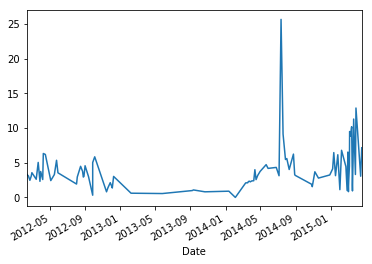

In [22]:
runs = cardio[cardio['Type'] == 'Running']
runs['Distance (mi)'].plot()

We can notice two things straight away:

* There's a gap at the start of 2014: this is probably where RunKeeper hasn't got information about the distance because my GPS watch didn't work right or something, and I don't want to include these in my analysis.
* There's a big spike from where I did the [12 Labours of Hercules ultramarathon](http://beyondmarathon.com/12-labours-of-hercules/), which isn't really an ordinary run so I don't want to include that either.

Let's do some filtering (excluding those, and some runs with "unreasonable" speeds that might be mislabelled runs or cycles) and try again.


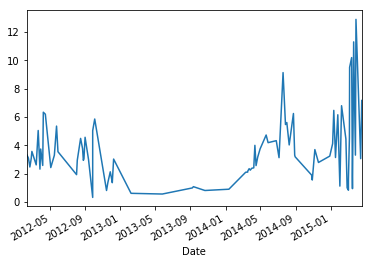

In [23]:
runs = runs[(runs['Distance (mi)'] <= 15)
            & runs['Average Speed (mph)'].between(3.5, 10)]
runs['Distance (mi)'].plot()

That looks much better. Now we can clearly see the break I took between late 2012 and early 2014 (problems with my iliotibial band), followed by a gradual return to training and an increase in distance leading up to my recent half-marathon.

There are other types of plot we can look at too. How about a histogram of my run distances?

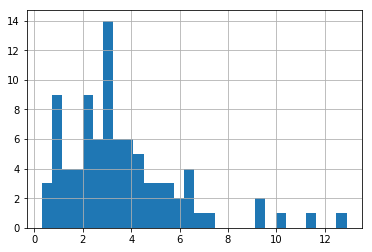

In [24]:
runs['Distance (mi)'].hist(bins=30)

You can clearly see here the divide between my usual weekday runs (usually around 3–5 miles) and my longer weekend runs. I've only been running >7 miles very recently, but I suspect as time goes on this graph will start to show two distinct peaks. There also seem to be peaks around whole numbers of miles: it looks like I have a tendency to finish my runs shortly after the distance readout on my watch ticks over! The smaller peak around 1 mile is where I run to the gym as a warmup before a strength workout.

How fast do I run? Let's take a look.

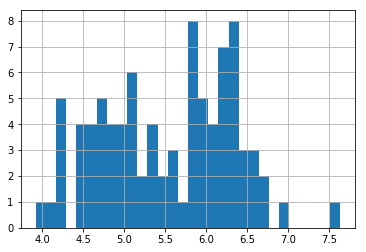

In [25]:
runs['Average Speed (mph)'].hist(bins=30)

Looks like another bimodal distribution. There's not really enough data here to be sure, but this could well be a distinction between longer, slower runs and shorter, faster ones. Let's try plotting distance against speed to get a better idea.

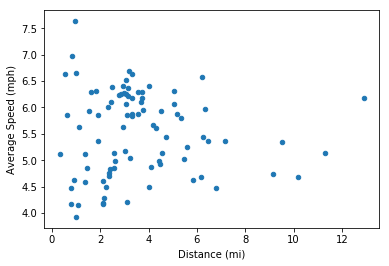

In [26]:
runs.plot(kind='scatter', x='Distance (mi)', y='Average Speed (mph)')

Hmm, no clear trend here. Maybe that's because when I first started running I was nowhere near so fit as I am now, so those early runs were both short and slow! What if we restrict it just to this year?

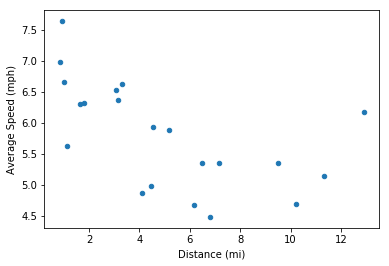

In [27]:
runs = runs.loc[runs.index > '2015-01-01']
runs.plot(kind='scatter', x='Distance (mi)', y='Average Speed (mph)')

That's better: now it's clear to see that, in general, the further I go, the slower I run!

So, as expected, no major insights. Now that I'm over my knee injury and back to training regularly, I'm hoping that I'll be able to collect more data and learn a bit more about how I exercise and maybe even make some improvements.